In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries and MoveNet

In [ ]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from PIL import Image

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:

# Download model from TF Hub and check out inference code from GitHub
!wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
!git clone https://github.com/tensorflow/examples.git


# !find /tmp/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

# Define function to run pose estimation using MoveNet Thunder.
# You'll apply MoveNet's cropping algorithm and run inference multiple times on
# the input image to improve pose estimation accuracy.
def detect(input_tensor, inference_count=3):
  """Runs detection on an input image.

  Args:
    input_tensor: A [height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.
    inference_count: Number of times the model should run repeatly on the
      same input image to improve detection accuracy.

  Returns:
    A Person entity detected by the MoveNet.SinglePose.
  """
  image_height, image_width, channel = input_tensor.shape

  # Detect pose using the full input image
  movenet.detect(input_tensor.numpy(), reset_crop_region=True)

  # Repeatedly using previous detection result to identify the region of
  # interest and only croping that region to improve detection accuracy
  for _ in range(inference_count - 1):
    person = movenet.detect(input_tensor.numpy(),
                            reset_crop_region=False)

  return person

Cloning into 'examples'...
remote: Enumerating objects: 23745, done.
remote: Total 23745 (delta 0), reused 0 (delta 0), pack-reused 23745
Receiving objects: 100% (23745/23745), 44.08 MiB | 22.21 MiB/s, done.
Resolving deltas: 100% (12942/12942), done.


In [ ]:
def draw_prediction_on_image(image, person, crop_region=None, close_figure=True, keep_input_size=False):
  # Draw the detection result on top of the image.
  image_np = utils.visualize(image, [person])

  # Plot the image with detection results.
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  im = ax.imshow(image_np)

  if close_figure:
    plt.close(fig)

  if not keep_input_size:
    image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))

  return image_np

In [ ]:
class MoveNetPreprocessor(object):
  def __init__(self,
               images_in_folder,
               images_out_folder,
               csvs_out_path):

    self._images_in_folder = images_in_folder
    self._images_out_folder = images_out_folder
    self._csvs_out_path = csvs_out_path
    self._messages = []

    # Create a temp dir to store the position CSVs per class
    self._csvs_out_folder_per_class = tempfile.mkdtemp()

    # Get list of position classes and print image statistics
    self._pose_class_names = sorted(
        [n for n in os.listdir(self._images_in_folder) if not n.startswith('.')]
        )

  def process(self, per_pose_class_limit=None, detection_threshold=0.1):
    # Loop through the classes and preprocess its images
    for pose_class_name in self._pose_class_names:
      print('Preprocessing', pose_class_name, file=sys.stderr)

      # Paths for the pose class.
      images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
      images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  pose_class_name + '.csv')
      if not os.path.exists(images_out_folder):
        os.makedirs(images_out_folder)

      # Detect landmarks in each image and write it to a CSV file
      with open(csv_out_path, 'w') as csv_out_file:
        csv_out_writer = csv.writer(csv_out_file,
                                    delimiter=',',
                                    quoting=csv.QUOTE_MINIMAL)
        # Get list of images
        image_names = sorted(
            [n for n in os.listdir(images_in_folder) if not n.startswith('.')])
        if per_pose_class_limit is not None:
          image_names = image_names[:per_pose_class_limit]

        valid_image_count = 0

        # Detect pose landmarks from each image
        for image_name in tqdm.tqdm(image_names):
          image_path = os.path.join(images_in_folder, image_name)

          try:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
          except:
            self._messages.append('Skipped ' + image_path + '. Invalid image.')
            continue
          else:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
            image_height, image_width, channel = image.shape

          # Skip images that isn't RGB because Movenet requires RGB images
          if channel != 3:
            self._messages.append('Skipped ' + image_path +
                                  '. Image isn\'t in RGB format.')
            continue
          person = detect(image)

          # Save landmarks if all landmarks were detected
          min_landmark_score = min(
              [keypoint.score for keypoint in person.keypoints])
          should_keep_image = min_landmark_score >= detection_threshold
          if not should_keep_image:
            self._messages.append('Skipped ' + image_path +
                                  '. No pose was confidentlly detected.')
            continue

          valid_image_count += 1

          # Draw the prediction result on top of the image for debugging later
          output_overlay = draw_prediction_on_image(
              image.numpy().astype(np.uint8), person,
              close_figure=True, keep_input_size=True)

          # Write detection result into an image file
          output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
          cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)

          # Get landmarks and scale it to the same size as the input image
          pose_landmarks = np.array(
              [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
                for keypoint in person.keypoints],
              dtype=np.float32)

          # Write the landmark coordinates to its per-class CSV file
          coordinates = pose_landmarks.flatten().astype(str).tolist()
          csv_out_writer.writerow([image_name] + coordinates)

        if not valid_image_count:
          raise RuntimeError(
              'No valid images found for the "{}" class.'
              .format(pose_class_name))

    # Print the error message collected during preprocessing.
    print('\n'.join(self._messages))

    # Combine all per-class CSVs into a single output file
    all_landmarks_df = self._all_landmarks_as_dataframe()
    all_landmarks_df.to_csv(self._csvs_out_path, index=False)

  def class_names(self):
    """List of classes found in the training dataset."""
    return self._pose_class_names

  def _all_landmarks_as_dataframe(self):
    """Merge all per-class CSVs into a single dataframe."""
    total_df = None
    for class_index, class_name in enumerate(self._pose_class_names):
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  class_name + '.csv')
      per_class_df = pd.read_csv(csv_out_path, header=None)

      # Add the labels
      per_class_df['class_no'] = [class_index]*len(per_class_df)
      per_class_df['class_name'] = [class_name]*len(per_class_df)

      # Append the folder name to the filename column (first column)
      per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '')
        + per_class_df[per_class_df.columns[0]].astype(str))

      if total_df is None:
        # For the first class, assign its data to the total dataframe
        total_df = per_class_df
      else:
        # Concatenate each class's data into the total dataframe
        total_df = pd.concat([total_df, per_class_df], axis=0)

    list_name = [[bodypart.name + '_x', bodypart.name + '_y',
                  bodypart.name + '_score'] for bodypart in BodyPart]
    header_name = []
    for columns_name in list_name:
      header_name += columns_name
    header_name = ['file_name'] + header_name
    header_map = {total_df.columns[i]: header_name[i]
                  for i in range(len(header_name))}

    total_df.rename(header_map, axis=1, inplace=True)

    return total_df

# Preprocess

In [ ]:
# Set up source path for datasets
source_path = '/content/drive/MyDrive/Capstone/Dataset/diamond_push_up'

source_path_start = os.path.join(source_path, 'start')
source_path_end = os.path.join(source_path, 'end')

print(f"There are {len(os.listdir(source_path_start))} images of start.")
print(f"There are {len(os.listdir(source_path_end))} images of end.")

There are 70 images of start.
There are 86 images of end.


There are 70 images of start.
There are 86 images of end.


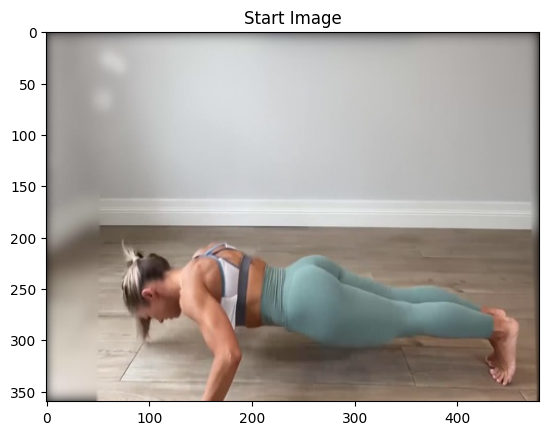

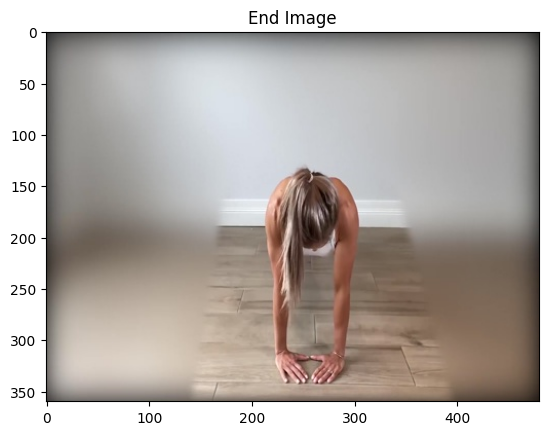

In [ ]:
def load_images(source_path_start, source_path_end):
    # List image files
    start_images = os.listdir(source_path_start)
    end_images = os.listdir(source_path_end)

    print(f"There are {len(start_images)} images of start.")
    print(f"There are {len(end_images)} images of end.")

    # Load images using OpenCV
    start_images_loaded = [cv2.imread(os.path.join(source_path_start, img)) for img in start_images]
    end_images_loaded = [cv2.imread(os.path.join(source_path_end, img)) for img in end_images]

    # Displaying the first image from each category as an example
    plt.imshow(cv2.cvtColor(start_images_loaded[0], cv2.COLOR_BGR2RGB))
    plt.title('Start Image')
    plt.show()

    plt.imshow(cv2.cvtColor(end_images_loaded[0], cv2.COLOR_BGR2RGB))
    plt.title('End Image')
    plt.show()

    return start_images_loaded, end_images_loaded

# Load images
start_images_loaded, end_images_loaded = load_images(source_path_start, source_path_end)

There are 70 images of start.
There are 86 images of end.


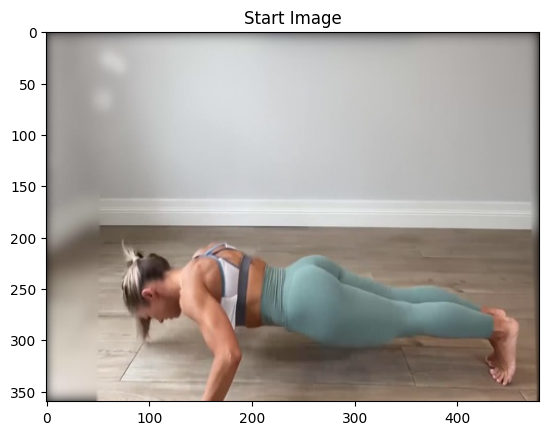

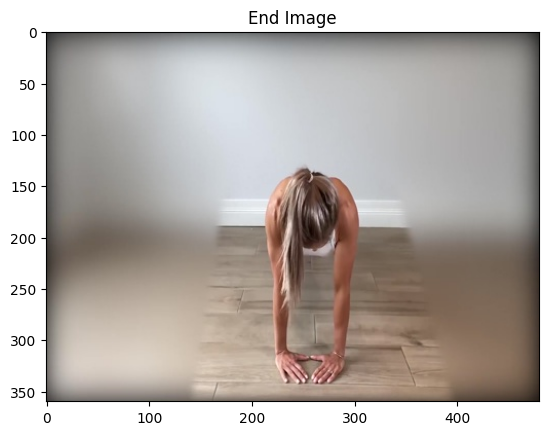

Training set: 56 start images, 68 end images
Validation set: 14 start images, 18 end images


In [ ]:
def split_dataset(images, train_size=0.8):
    # First split into train and val+test
    train_images, val_images = train_test_split(images, train_size=train_size, random_state=42)

    return train_images, val_images

start_images_loaded, end_images_loaded = load_images(source_path_start, source_path_end)

# Split the datasets
train_start, val_start = split_dataset(start_images_loaded)
train_end, val_end = split_dataset(end_images_loaded)

print(f"Training set: {len(train_start)} start images, {len(train_end)} end images")
print(f"Validation set: {len(val_start)} start images, {len(val_end)} end images")
# print(f"Test set: {len(test_start)} start images, {len(test_end)} end images")

In [ ]:
# Define output directories
output_dir = '/content/drive/MyDrive/Capstone/Dataset/diamond_push_up/output'
# train_start_dir = os.path.join(output_dir, '0')
# train_end_dir = os.path.join(output_dir, '1')

# val_start_dir = os.path.join(output_dir, '0')
# val_end_dir = os.path.join(output_dir, '1')

train_dir = os.path.join(output_dir, 'train_data')
val_dir = os.path.join(output_dir, 'val_data')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

def save_images_to_directory(images, directory, label):
    """
    Save images to the specified directory with corresponding labels as subdirectories.
    Args:
        images (np.array): Array of images.
        labels (np.array): Array of labels.
        directory (str): Directory to save the images.
    """

    label_dir = os.path.join(directory, str(label))
    os.makedirs(label_dir, exist_ok=True)
    for i, image in enumerate(images):
        image_path = os.path.join(label_dir, f"{i}.jpg")
        # cv2.imwrite(image_path, image)
        try:
            if image is None or image.size == 0:
                raise ValueError(f"Image {i} is empty or None.")
            if not cv2.imwrite(image_path, image):
                raise IOError(f"Failed to save image {i} to {image_path}.")
            print(f"Image {i} saved to {image_path}")
        except Exception as e:
            print(f"Error saving image {i} to {image_path}: {e}")

save_images_to_directory(train_start, train_dir, label=0)
save_images_to_directory(train_end, train_dir, label=1)
save_images_to_directory(val_start, val_dir, label=0)
save_images_to_directory(val_end, val_dir, label=1)

print("Images saved to directories.")

Image 0 saved to /content/drive/MyDrive/Capstone/Dataset/diamond_push_up/output/train_data/0/0.jpg
Image 1 saved to /content/drive/MyDrive/Capstone/Dataset/diamond_push_up/output/train_data/0/1.jpg
Image 2 saved to /content/drive/MyDrive/Capstone/Dataset/diamond_push_up/output/train_data/0/2.jpg
Image 3 saved to /content/drive/MyDrive/Capstone/Dataset/diamond_push_up/output/train_data/0/3.jpg
Image 4 saved to /content/drive/MyDrive/Capstone/Dataset/diamond_push_up/output/train_data/0/4.jpg
Image 5 saved to /content/drive/MyDrive/Capstone/Dataset/diamond_push_up/output/train_data/0/5.jpg
Image 6 saved to /content/drive/MyDrive/Capstone/Dataset/diamond_push_up/output/train_data/0/6.jpg
Image 7 saved to /content/drive/MyDrive/Capstone/Dataset/diamond_push_up/output/train_data/0/7.jpg
Image 8 saved to /content/drive/MyDrive/Capstone/Dataset/diamond_push_up/output/train_data/0/8.jpg
Image 9 saved to /content/drive/MyDrive/Capstone/Dataset/diamond_push_up/output/train_data/0/9.jpg
Image 10 s

In [ ]:
train_dir = '/content/drive/MyDrive/Capstone/Dataset/diamond_push_up/output/train_data'
val_dir = '/content/drive/MyDrive/Capstone/Dataset/diamond_push_up/output/val_data'
test_dir = '/content/drive/MyDrive/Capstone/Dataset/diamond_push_up/output/test_data'

In [ ]:
def preprocess_data(input_dir, output_dir):
    csv_out_path = input_dir + '/_landmark.csv'

    preprocessor = MoveNetPreprocessor(
        images_in_folder=input_dir,
        images_out_folder=output_dir,
        csvs_out_path=csv_out_path
    )
    preprocessor.process()

train_output = '/content/drive/MyDrive/Capstone/Dataset/diamond_push_up/train_output'
val_output = '/content/drive/MyDrive/Capstone/Dataset/diamond_push_up/val_output'
test_output = '/content/drive/MyDrive/Capstone/Dataset/diamond_push_up/test_output'

# Process the data and save the CSV
# preprocess_data(train_dir, train_output)
preprocess_data(val_dir, val_output)
# preprocess_data(test_dir, test_output)


Preprocessing 0
100%|██████████| 14/14 [00:54<00:00,  3.90s/it]
Preprocessing 1
100%|██████████| 18/18 [01:09<00:00,  3.87s/it]

# Load Data

In [ ]:
train_dir = '/content/drive/MyDrive/Capstone/Dataset/diamond_push_up/output/train_data'
val_dir = '/content/drive/MyDrive/Capstone/Dataset/diamond_push_up/output/val_data'
test_dir = '/content/drive/MyDrive/Capstone/Dataset/diamond_push_up/output/test_data'

In [ ]:
def load_data(file_path): #, label):
  full_path = os.path.join(file_path, '_landmark.csv')

  # df = pd.read_csv(file_path + '/_landmark.csv')
  print(f"File found at: {full_path}. Attempting to read CSV...")  # Debugging reading CSV

  try:
        df = pd.read_csv(full_path)
        print("CSV file read successfully!")  # Debugging success message
  except Exception as e:
        print(f"Error reading the CSV file: {e}")  # Debugging error message
        raise
  df = pd.read_csv(full_path)
  df_to_process = df.copy()
  classes = df_to_process.pop('class_name').unique()
  y = df_to_process.pop('class_no')
  df_to_process = df_to_process.drop(df_to_process.columns[0], axis=1)
  x = df_to_process.astype('float64') #.values
  y = keras.utils.to_categorical(y)
  return x, y, classes, df_to_process
try:
  x_train, y_train, class_names, df_start_train = load_data(train_dir)
  x_val, y_val, class_names, df_start_train = load_data(val_dir)
  x_test, y_test, class_names, df_start_train = load_data(test_dir)

except Exception as e:
  print(f"Error loading data: {e}")


File found at: /content/drive/MyDrive/Capstone/Dataset/diamond_push_up/output/train_data/_landmark.csv. Attempting to read CSV...
CSV file read successfully!
File found at: /content/drive/MyDrive/Capstone/Dataset/diamond_push_up/output/val_data/_landmark.csv. Attempting to read CSV...
CSV file read successfully!
File found at: /content/drive/MyDrive/Capstone/Dataset/diamond_push_up/output/test_data/_landmark.csv. Attempting to read CSV...
CSV file read successfully!


In [ ]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
  """Calculates the center point of the two given landmarks."""

  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
  """Calculates pose size.

  It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
  """
  # Hips center
  hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                 BodyPart.RIGHT_HIP)

  # Shoulders center
  shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                     BodyPart.RIGHT_HIP)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to
  # perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_landmarks(landmarks):
  """Normalizes the landmarks translation by moving the pose center to (0,0) and
  scaling it to a constant pose size.
  """
  # Move landmarks so that the pose center becomes (0,0)
  pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                 BodyPart.RIGHT_HIP)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform
  # substraction
  pose_center = tf.broadcast_to(pose_center,
                                [tf.size(landmarks) // (17*2), 17, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_and_scores):
  """Converts the input landmarks into a pose embedding."""
  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

# Build and Train Model

In [ ]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(64, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.2)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.3)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
outputs = keras.layers.Dense(2, activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 51)]                 0         []                            
                                                                                                  
 reshape_1 (Reshape)         (None, 17, 3)                0         ['input_2[0][0]']             
                                                                                                  
 tf.__operators__.getitem_1  (None, 17, 2)                0         ['reshape_1[0][0]']           
  (SlicingOpLambda)                                                                               
                                                                                                  
 tf.compat.v1.gather_9 (TFO  (None, 2)                    0         ['tf.__operators__.getit

In [ ]:
checkpoint_path = "weights.best.h5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                             monitor = 'val_accuracy',
                                             verbose = 1,
                                             save_best_only = True,
                                             mode = 'max')
earlystopping = keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                              patience = 20)


In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=20)

#Start training
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=16,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/20
7/8 [=========================>....] - ETA: 0s - loss: 0.6905 - accuracy: 0.6696 
Epoch 1: val_accuracy improved from -inf to 0.78125, saving model to weights.best.hdf5
8/8 [==============================] - 6s 196ms/step - loss: 0.6907 - accuracy: 0.6579 - val_loss: 0.6868 - val_accuracy: 0.7812
Epoch 2/20
1/8 [==>...........................] - ETA: 0s - loss: 0.6869 - accuracy: 0.7500
Epoch 2: val_accuracy improved from 0.78125 to 0.87500, saving model to weights.best.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 19ms/step - loss: 0.6850 - accuracy: 0.7105 - val_loss: 0.6780 - val_accuracy: 0.8750
Epoch 3/20
1/8 [==>...........................] - ETA: 0s - loss: 0.6716 - accuracy: 0.9375
Epoch 3: val_accuracy did not improve from 0.87500
8/8 [==============================] - 0s 11ms/step - loss: 0.6759 - accuracy: 0.7544 - val_loss: 0.6657 - val_accuracy: 0.8438
Epoch 4/20
1/8 [==>...........................] - ETA: 0s - loss: 0.6808 - accuracy: 0.6875
Epoch 4: val_accuracy did not improve from 0.87500
8/8 [==============================] - 0s 10ms/step - loss: 0.6661 - accuracy: 0.7807 - val_loss: 0.6513 - val_accuracy: 0.8125
Epoch 5/20
1/8 [==>...........................] - ETA: 0s - loss: 0.6466 - accuracy: 0.7500
Epoch 5: val_accuracy did not improve from 0.87500
8/8 [==============================] - 0s 12ms/step - loss: 0.6469 - accuracy: 0.7982 - val_loss: 0.6327 - val_accuracy: 0.8438
Epoch 6/20
1/8 [==>...........................] - ETA: 0s -

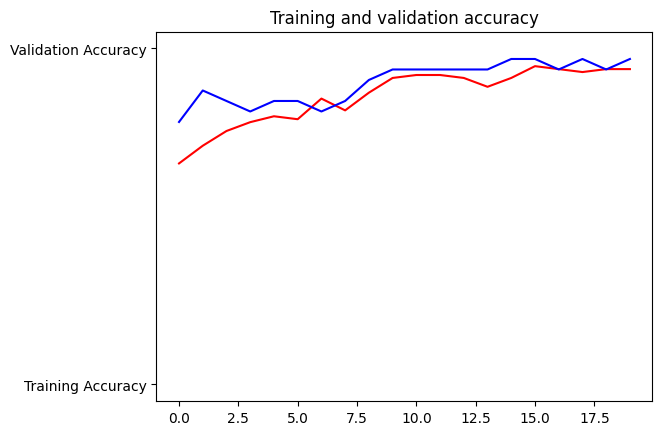

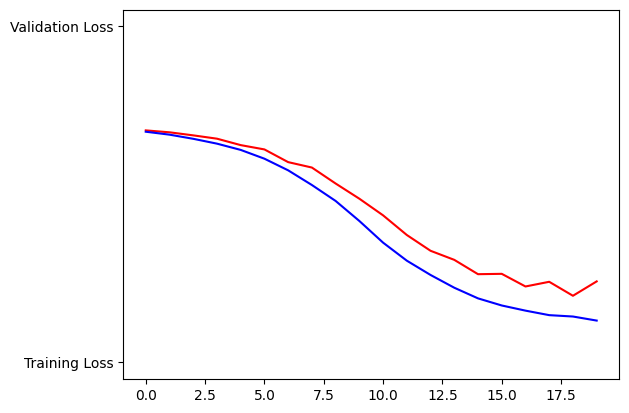

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [ ]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 274ms/step - loss: 0.1139 - accuracy: 1.0000


In [ ]:
# Muat model TensorFlow Anda (misalnya model .h5)
model = tf.keras.models.load_model('weights.best.hdf5')

# Konversi model ke format TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite ke file
tflite_model_path = 'diamond_push_up_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)